In [64]:
import os
import time
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [322]:
def load_files(path):
    
    names = glob.glob(path)
    file_list = []
    name_list = []
    for i, name in enumerate(names):
        assert len(name) == 22
        name_list.append([name[12:18]])
        sub = pd.read_csv(name)
        file_list.append(sub)
        
    return file_list, name_list

In [171]:
def scailing(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace = True)
    
    X = data.iloc[:-1, 1:]
    y = data.iloc[1:, :1]

    ms = MinMaxScaler()
    ss = StandardScaler()

    X_ss = ss.fit_transform(X)
    y_ms = ms.fit_transform(y)

    ratios = [.8, .2]

    train_cnt = int(len(data) * ratios[0])
    test_cnt = int(len(data) * ratios[1])

    X_train = X_ss[:train_cnt, :]
    X_test = X_ss[train_cnt:, :]

    y_train = y_ms[:train_cnt, :]
    y_test = y_ms[train_cnt:, :]

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test))

    X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
    
    return X_train_tensors_f, X_test_tensors_f, y_train_tensors, y_test_tensors

In [172]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                           num_layers = num_layers, batch_first = True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [173]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.loss = np.inf
        self.patience = 0
        self.patience_limit = patience
        
    def step(self, loss):
        if self.loss > loss:
            self.loss = loss
            self.patience = 0
        else:
            self.patience += 1
    
    def is_stop(self):
        return self.patience >= self.patience_limit

In [249]:
def training(X_train_tensors_f, y_train_tensors):
    num_epochs = 20000
    learning_rate = 0.001

    input_size = 5
    hidden_size = 2
    num_layers = 1

    num_classes = 1
    model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    early_stop = EarlyStopping(patience=20)

    for epoch in range(num_epochs):
        outputs = model.forward(X_train_tensors_f)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train_tensors)
        early_stop.step(loss.item())

        loss.backward()

        optimizer.step()

        if early_stop.is_stop():
            break

    return model, loss.item()

In [255]:
def predict(df, model):
    df_x_ss = ss.transform(data.iloc[:-1, 1:])
    df_y_ms = ms.transform(data.iloc[1:, :1])

    df_x_ss = Variable(torch.Tensor(df_x_ss))
    df_y_ms = Variable(torch.Tensor(df_y_ms))
    df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

    train_predict = model(df_x_ss)
    predicted = train_predict.data.numpy()
    label_y = df_y_ms.data.numpy()

    predicted = ms.inverse_transform(predicted)
    label_y = ms.inverse_transform(label_y)
    
    return predicted, label_y

In [243]:
def plot_chart(predictd, label_y):
    plt.figure(figsize = (20, 10))
    plt.axvline(x = train_cnt, c = 'r', linestyle = '--')

    plt.plot(predicted, label = 'Predicted Data')
    plt.plot(label_y, label = 'Actual Data')
    plt.title('Time-Series Prediction')
    plt.legend()
    plt.show()

In [326]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [325]:
def save_values(model, label_y, predicted):
    PATH = f"../../Model/%d.pth" % name_list[i]
    torch.save(model.state_dict(), PATH)
    

In [323]:
file_list, name_list = load_files('../../Data2/*.csv')


In [324]:
name_list

[['000020'],
 ['000030'],
 ['000040'],
 ['000050'],
 ['000060'],
 ['000070'],
 ['000080'],
 ['000100'],
 ['000120'],
 ['000140'],
 ['000150'],
 ['000180'],
 ['000210'],
 ['000220'],
 ['000230'],
 ['000240'],
 ['000270'],
 ['000300'],
 ['000320'],
 ['000370'],
 ['000390'],
 ['000400'],
 ['000430'],
 ['000480'],
 ['000490'],
 ['000500'],
 ['000520'],
 ['000540'],
 ['000590'],
 ['000640'],
 ['000650'],
 ['000660'],
 ['000670'],
 ['000680'],
 ['000700'],
 ['000720'],
 ['000760'],
 ['000810'],
 ['000850'],
 ['000860'],
 ['000880'],
 ['000890'],
 ['000910'],
 ['000950'],
 ['000970'],
 ['000990'],
 ['001020'],
 ['001040'],
 ['001060'],
 ['001070'],
 ['001080'],
 ['001120'],
 ['001130'],
 ['001140'],
 ['001200'],
 ['001210'],
 ['001230'],
 ['001250'],
 ['001260'],
 ['001270'],
 ['001290'],
 ['001340'],
 ['001360'],
 ['001380'],
 ['001390'],
 ['001420'],
 ['001430'],
 ['001440'],
 ['001450'],
 ['001460'],
 ['001470'],
 ['001500'],
 ['001510'],
 ['001520'],
 ['001530'],
 ['001550'],
 ['001560'],

In [317]:
c.append([names[1][12:18]])

In [318]:
c

['000020', '000030', ['000030']]

In [304]:
a = []
a

[]

In [311]:
a.append(names[1][12:18])

In [307]:
a.append('0203')

In [312]:
a

['s', '0203', '000020', '000030']

In [247]:
data = pd.read_csv('../../Data2/000020.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [248]:
X1, X2, y1, y2 = scailing(data)

In [251]:
model1, loss1 = training(X1, y1)

In [256]:
p1, ly1 = predict(data, model1)

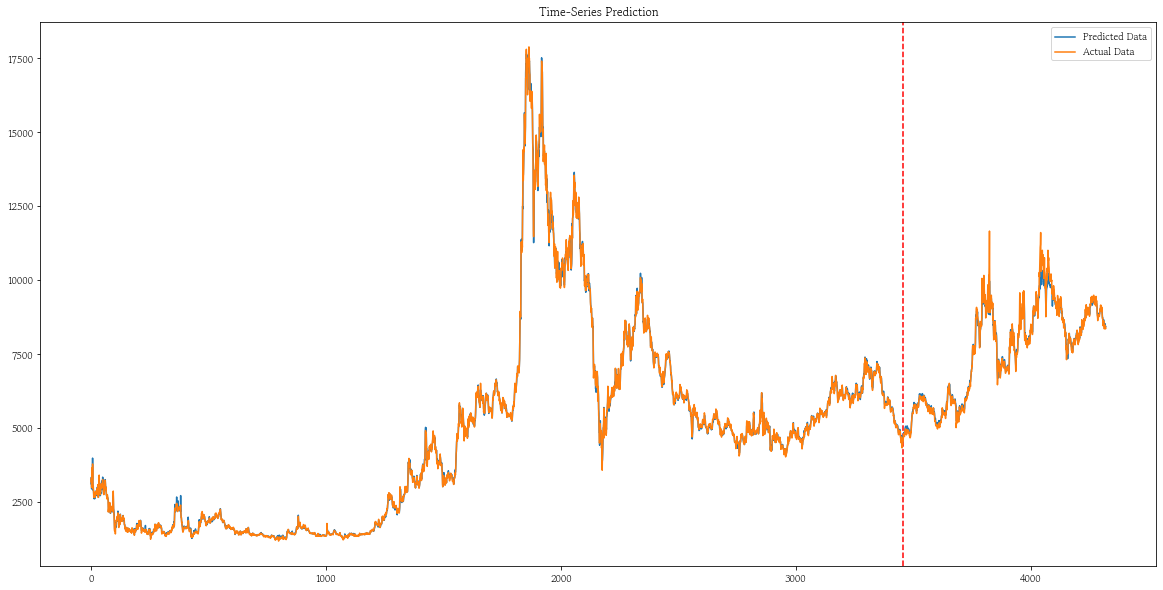

In [267]:
plot_chart(p1, ly1)

In [269]:
MAE(p1, ly1)

122.66531

In [268]:
save_values(model1, p1, ly1)

In [66]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)

In [212]:
X = data.iloc[:-1, 1:]
y = data.iloc[1:, :1]
print(X)
print(y)

                   High          Low         Close    Adj Close   Volume
Date                                                                    
2000-01-04  3110.570068  2658.120117  15552.850586  2752.192383   898582
2000-01-05  3572.439941  2940.899902  16495.451172  2918.992432  3865389
2000-01-06  3468.750000  2808.939941  14327.450195  2535.348633  1382353
2000-01-07  3289.659912  2827.790039  16448.298828  2910.648682  2402938
2000-01-10  3694.979980  3157.699951  16024.150391  2835.592041  3993227
...                 ...          ...           ...          ...      ...
2017-06-30  8540.000000  8410.000000   8470.000000  8470.000000    48558
2017-07-03  8510.000000  8410.000000   8440.000000  8440.000000    25073
2017-07-04  8490.000000  8370.000000   8430.000000  8430.000000    44152
2017-07-05  8440.000000  8300.000000   8340.000000  8340.000000    62841
2017-07-06  8420.000000  8300.000000   8400.000000  8400.000000    48957

[4321 rows x 5 columns]
                   Open
Da

In [213]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

ratios = [.8, 0, 0.2]

train_cnt = int(len(data) * ratios[0])
valid_cnt = int(len(data) * ratios[1])
test_cnt = int(len(data) * ratios[2])

X_train = X_ss[:train_cnt, :]
X_valid = X_ss[train_cnt:train_cnt + valid_cnt, :]
X_test = X_ss[train_cnt + valid_cnt:, :]

y_train = y_ms[:train_cnt, :]
y_valid = y_ms[train_cnt:train_cnt + valid_cnt, :]
y_test = y_ms[train_cnt + valid_cnt:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Validing Shape", X_valid.shape, y_valid.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (3457, 5) (3457, 1)
Validing Shape (0, 5) (0, 1)
Testing Shape (864, 5) (864, 1)


In [214]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_valid_tensors = Variable(torch.Tensor(X_valid))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_valid_tensors = Variable(torch.Tensor(y_valid))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_valid_tensors_f = torch.reshape(X_valid_tensors, (X_valid_tensors.shape[0], 1, X_valid_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Validing Shape", X_valid_tensors_f.shape, y_valid_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([3457, 1, 5]) torch.Size([3457, 1])
Validing Shape torch.Size([0, 1, 5]) torch.Size([0, 1])
Testing Shape torch.Size([864, 1, 5]) torch.Size([864, 1])


In [215]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                           num_layers = num_layers, batch_first = True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [216]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.loss = np.inf
        self.patience = 0
        self.patience_limit = patience
        
    def step(self, loss):
        if self.loss > loss:
            self.loss = loss
            self.patience = 0
        else:
            self.patience += 1
    
    def is_stop(self):
        return self.patience >= self.patience_limit

In [217]:
num_epochs = 20000
learning_rate = 0.001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

early_stop = EarlyStopping(patience=20)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    early_stop.step(loss.item())
    
    loss.backward()
            
    optimizer.step()
    
    if early_stop.is_stop():
        print("Earlystop at %d" % (epoch + 1))
        break

    
    if (epoch + 1) % 500 == 0:
        print("Epoch: %d, loss: %1.8f" % (epoch + 1, loss.item()))


Epoch: 500, loss: 0.00010940
Epoch: 1000, loss: 0.00006218
Epoch: 1500, loss: 0.00004673
Epoch: 2000, loss: 0.00003928
Epoch: 2500, loss: 0.00003397
Epoch: 3000, loss: 0.00003047
Epoch: 3500, loss: 0.00002866
Earlystop at 3982


In [175]:
num_epochs = 20000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

early_stop = EarlyStopping(patience=20)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    early_stop.step(loss.item())
    
    loss.backward()
            
    optimizer.step()
    
    if early_stop.is_stop():
        print("Earlystop at %d" % (epoch + 1))
        break

    
    if (epoch + 1) % 500 == 0:
        print("Epoch: %d, loss: %1.8f" % (epoch + 1, loss.item()))


Epoch: 500, loss: 0.00890492
Epoch: 1000, loss: 0.00315517
Epoch: 1500, loss: 0.00167196
Epoch: 2000, loss: 0.00086427
Epoch: 2500, loss: 0.00048426
Epoch: 3000, loss: 0.00032927
Epoch: 3500, loss: 0.00022956
Epoch: 4000, loss: 0.00016372
Epoch: 4500, loss: 0.00011958
Epoch: 5000, loss: 0.00009233
Epoch: 5500, loss: 0.00007598
Epoch: 6000, loss: 0.00006512
Epoch: 6500, loss: 0.00005651
Epoch: 7000, loss: 0.00004988
Epoch: 7500, loss: 0.00004506
Epoch: 8000, loss: 0.00004154
Epoch: 8500, loss: 0.00003899
Epoch: 9000, loss: 0.00003712
Epoch: 9500, loss: 0.00003573
Epoch: 10000, loss: 0.00003462
Epoch: 10500, loss: 0.00003366
Epoch: 11000, loss: 0.00003278
Epoch: 11500, loss: 0.00003200
Epoch: 12000, loss: 0.00003128
Epoch: 12500, loss: 0.00003065
Epoch: 13000, loss: 0.00003010
Epoch: 13500, loss: 0.00002964
Epoch: 14000, loss: 0.00002932
Epoch: 14500, loss: 0.00002912
Earlystop at 14791


In [218]:
df_x_ss = ss.transform(data.iloc[:, 1:])
df_y_ms = ms.transform(data.iloc[:, :1])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

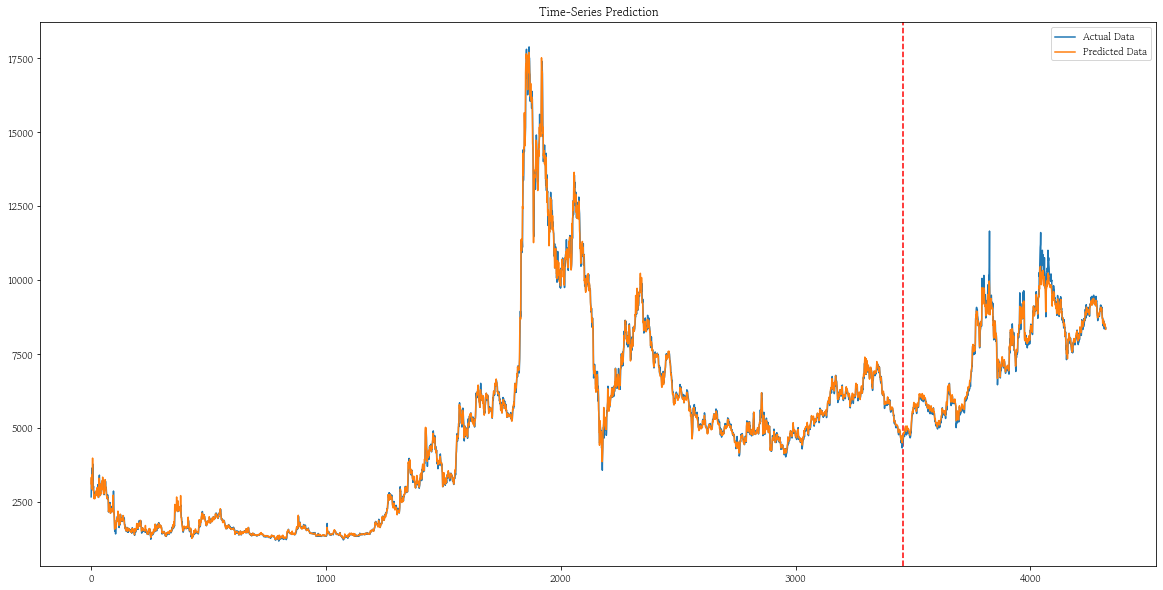

In [219]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize = (20, 10))
plt.axvline(x = train_cnt, c = 'r', linestyle = '--')

plt.plot(label_y, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [220]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(label_y, predicted))

MAE SCORE :  91.57332


In [ ]:
# 모델 저장

PATH = f"../../Model/{}.pth"
torch.save(model.state_dict(), PATH)

In [221]:
len(df_x_ss)

4322

In [222]:
len(label_y)

4322

In [223]:
len(predicted)

4322

In [224]:
df_x_ss[-1]

tensor([[ 0.9149,  0.9644, -0.3883,  1.1439, -0.3497]])

In [225]:
label_y[-1]

array([8370.], dtype=float32)

In [226]:
predicted[-1]

array([8326.874], dtype=float32)

In [227]:
data

Open         High          Low         Close    Adj Close  \
Date                                                                           
2000-01-04  2658.120117  3110.570068  2658.120117  15552.850586  2752.192383   
2000-01-05  3167.120117  3572.439941  2940.899902  16495.451172  2918.992432   
2000-01-06  3299.090088  3468.750000  2808.939941  14327.450195  2535.348633   
2000-01-07  2978.600098  3289.659912  2827.790039  16448.298828  2910.648682   
2000-01-10  3638.419922  3694.979980  3157.699951  16024.150391  2835.592041   
...                 ...          ...          ...           ...          ...   
2017-07-03  8470.000000  8510.000000  8410.000000   8440.000000  8440.000000   
2017-07-04  8450.000000  8490.000000  8370.000000   8430.000000  8430.000000   
2017-07-05  8430.000000  8440.000000  8300.000000   8340.000000  8340.000000   
2017-07-06  8340.000000  8420.000000  8300.000000   8400.000000  8400.000000   
2017-07-07  8370.000000  8370.000000  8190.000000   8270.000000  8270.000000   

             Volume  
Date                 
2000-01-04   898582  
2000-01-05  3865389  
2000-01-06  1382353  
2000-01-07  2402938  
2000-01-10  3993227  
...             ...  
2017-07-03    25073  
2017-07-04    44152  
2017-07-05    62841  
2017-07-06    48957  
2017-07-07    91431  

[4322 rows x 6 columns]

In [235]:
predicted1 = ms.inverse_transform(model(df_x_ss[-1:]).data.numpy())
predicted1

array([[8326.874]], dtype=float32)

In [233]:
model(df_x_ss[-1:])

tensor([[0.4286]], grad_fn=<AddmmBackward0>)